# Prediction Step:
With this step all we know is the starting conditions and the mean/variance of the accelerations, so 

1 [0.0, -1.424781324101176]
2 [-0.712390662050588, 0.795142095268818]
3 [0.04137571660911499, -0.04763044006699192]
4 [-0.0031273617289384673, 0.900497315762641]
5 [1.793786685467861, 3.1388883939188705]


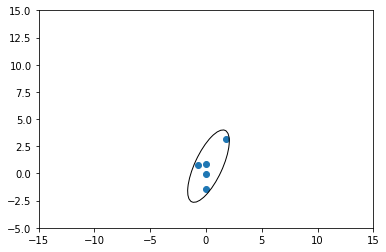

In [1]:
"""
FULL DISCLOSURE: I looked up how to do ellipses with matplotlib here: 
https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib
I'm not 100% certain about it, but it looks good so I'm going with it for now.
"""

from math import *
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np

# How many timesteps to simulate
iters = 5
# Seed for repeatable randomness
rseed = 13
m = 0     #mean of accelerations
v = 1.0     #variance of accelerations

# Starting Variables
t = 0       #current time
x = 0     #current position
xmean = 0 #current position belief mean
xvar = 0  #current position variance
xdot = 0  #current velocity
a = 0     #current acceleration

# Generating Random Accels According to Distribution
random_state = np.random.RandomState(rseed)
accels = random_state.normal(m, v, iters)

# Initialize Arrays for Later
xs = np.zeros(iters)
xdots = np.zeros(iters)

# simple enough to just add what we know
def predict(mean1, var1, mean2, var2):
    nmean = mean1 + mean2
    nvar = var1 + var2
    return [nmean, nvar]

for tstep in range(iters):
    xs[tstep] = xmean
    xdot += accels[tstep]
    xdots[tstep] = xdot + accels[tstep]
    xmean, xvar = predict(xmean, xvar, accels[tstep], v)
xs[tstep] = xmean
xdot += accels[tstep] 
xdots[tstep] = xdot

for tstep in range(iters):
    print(tstep + 1, "[" + str(xs[tstep]) + ", " + str(xdots[tstep]) + "]")


#### Plotting Ellipses ####

def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

nstd = 2
ax = plt.subplot(111)

cov = np.cov(xs,xdots)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
w, h = 2 * nstd * np.sqrt(vals)
ell = Ellipse(xy=(np.mean(xs), np.mean(xdots)),
              width=w, height=h,
              angle=theta, color='black')
ell.set_facecolor('none')
ax.add_artist(ell)
plt.scatter(xs, xdots)
plt.ylim([-5,15])
plt.xlim([-15,15])

plt.show()

# Part 2

In [2]:
def update(mean1, var1, mean2, var2):
    new_mean = (var2 * mean1 + var1 * mean2) / (var2 + var1)
    new_var = 1 / (1 / var2 + 1 / var1)
    return [new_mean, new_var]

print("Before: [", str(xs[tstep]) + ", " + str(xdots[tstep]) + "]")

measure = 10.0
m_var = 8.0

m_x, m_xdot = update(xs[tstep], xdots[tstep], measure, m_var)

print("After:  [", str(m_x) + ", " + str(m_xdot) + "]")  



#### Adapting to measure randomly ####
"""
It seems like the sensor data needs to be created by adding noise to a ground truth rather than 
the prior beliefs which may wander, so I am quickly going to generate ground truths.
"""
def runthething(inters, chance):
    xmean = 0.0
    xvar = 0.0
    xdot = 0.0
    accels = np.zeros(iters)
    xs = np.zeros(iters)
    xdots = np.zeros(iters)
    true_x = np.zeros(iters)
    true_dotx = np.zeros(iters)
    #generate ground truth accelerations
    true_accels = random_state.normal(m, v, iters)
    
    for tstep in range(iters):
        #generate noisy accelerations
        accels[tstep] = true_accels[tstep] + random_state.normal(0.0, .5)
        #Generate ground truth velocities
        if tstep > 0:
            true_dotx[tstep] = true_dotx[tstep-1] + true_accels[tstep]
        #generate ground truth positions
        if tstep > 0:
            true_x[tstep] = true_x[tstep-1] + true_dotx[tstep]

            
    for tstep in range(iters):
        if tstep > 0:
            xs[tstep] = xmean
            xdot += accels[tstep]
            xdots[tstep] = xdot + accels[tstep]
        xmean, xvar = predict(xmean, xvar, accels[tstep], v)
        # Has a chance out of 10 chance to measure
        if random_state.randint(1,10) >= chance and tstep > 0:
            # Measurement based on ground truth and stated variance, normally distributed.
            measure = true_x[tstep] + random_state.normal(0.0, 8.0)
            xmean, xvar = update(xs[tstep], xdots[tstep], measure, m_var)
    xs[tstep] = xmean
    xdot += accels[tstep] 
    xdots[tstep] = xdot
    return xs[-1], true_x[-1]
    
calcend, realend = runthething(10, 2)
print("calculated: " + str(calcend))
print("real end:   " + str(realend))

Before: [ 1.793786685467861, 3.1388883939188705]
After:  [ 4.106260499737325, 2.2543638344612593]
calculated: 11.343069510637937
real end:   9.896380065731329


# 2.3 here for clarity's sake
It's a big boy so it gets its own box.

In [3]:
onetenthrun = np.zeros(10)
onehalfrun = np.zeros(10)
ninetenthsrun = np.zeros(10)

for i in range(10):
    calc, real = runthething(20, 9)
    onetenthrun[i] = calc - real

print(".1 : " + str(np.mean(onetenthrun)))
    
for i in range(10):
    calc, real = runthething(20, 5)
    onehalfrun[i] = calc - real
    
print(".5 : " + str(np.mean(onehalfrun)))
    
for i in range(10):
    calc, real = runthething(20, 1)
    ninetenthsrun[i] = calc - real
    
print(".9 : " + str(np.mean(ninetenthsrun)))

.1 : 1.8529385298878882
.5 : 2.2244605600049594
.9 : 2.232922383287027
